# Cross-Matching VOICE-VST Photometric and Spectroscopic Redshift Catalogs

Zack Hutchens - June 2019

In [1]:
import numpy as np
import pandas as pd
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import matplotlib.pyplot as plt
from scipy.stats import mode, ttest_rel, linregress
from astropy.io import fits
import os

#os.chdir(r'C:\Users\mugdhapolimera\github\xray\catalog_matching')
def allUnique(x):
    seen = set()
    return not any(i in seen or seen.add(i) for i in x)

In [54]:
spec_file = r"../../SDSS_spectra/ECO+RESOLVE_filter_new.csv"
#phot_file = r"~/Desktop/3XMM_DR8_slim.csv"

# Read in RA + Dec from both catalogs
sdf = pd.read_csv(spec_file)
sdf
#pdf = np.genfromtxt(phot_file, delimiter = ' ')

,name,2hmag,2jmag,2kmag,Flux_ArIV_4711,Flux_ArIV_4711_Err,Flux_Ha_6562,Flux_Ha_6562_Err,Flux_Hb_4861,Flux_Hb_4861_Err,...,uhmag,ukmag,umag,uvm2mag,uymag,vdisp,vrot,w20,w50,zmag
0,ECO00001,10.6681,11.3352,10.3981,0.000000,0.000000,762.90740,45.044120,216.807700,18.672810,...,NaN,NaN,15.1108,NaN,NaN,NaN,NaN,NaN,NaN,12.5187
1,ECO00004,0.0000,15.6809,0.0000,3.796918,5.457565,367.16570,5.393764,136.534500,4.905726,...,NaN,NaN,18.7147,NaN,NaN,NaN,NaN,NaN,NaN,17.0119
2,ECO00008,0.0000,14.9374,0.0000,3.235835,5.928092,100.48830,2.953987,36.929670,4.100244,...,NaN,NaN,18.0984,NaN,NaN,NaN,NaN,NaN,NaN,16.3987
3,ECO00017,0.0000,0.0000,0.0000,4.600802,8.096721,269.33960,11.380110,92.569330,7.235629,...,NaN,NaN,18.2803,NaN,NaN,NaN,NaN,NaN,NaN,16.9597
4,ECO00018,14.6532,0.0000,0.0000,0.000000,0.000000,80.58173,2.285592,26.555270,3.114907,...,NaN,NaN,18.4596,NaN,NaN,NaN,NaN,NaN,NaN,16.6954
5,ECO00023,0.0000,15.8168,0.0000,0.000000,0.000000,233.51200,5.082335,76.474240,5.392159,...,NaN,NaN,18.4026,NaN,NaN,NaN,NaN,NaN,NaN,17.0292
6,ECO00027,14.6257,15.2075,0.0000,0.687655,64.472980,1481.71400,58.020990,435.446000,25.588100,...,NaN,NaN,17.8973,NaN,NaN,NaN,NaN,NaN,NaN,16.3955
7,ECO00035,13.6643,14.6946,13.8489,11.257160,7.118070,332.89550,13.637080,136.962000,12.456510,...,NaN,NaN,17.3068,NaN,NaN,NaN,NaN,NaN,NaN,15.6412
8,ECO00036,14.2517,15.7710,0.0000,3.340010,4.201066,242.22560,4.278423,82.303180,3.145890,...,NaN,NaN,17.8338,NaN,NaN,NaN,NaN,NaN,NaN,16.5019
9,ECO00054,0.0000,15.9998,0.0000,2.400507,12.771510,232.29400,3.978454,80.842630,4.806904,...,NaN,NaN,18.7095,NaN,NaN,NaN,NaN,NaN,NaN,17.4474


In [111]:
phot_file = r'../../SDSS_spectra/Broadlineagn.fits'
#pdf = pd.read_csv(phot_file, delimiter = ',')
from astropy.io import fits
from astropy.table import Table
pdf_fits = Table.read(phot_file)
pdf = pdf_fits.to_pandas()
pdf = pdf.rename(columns = {'DESIGNATION':'Name',"RA":'radeg', 'DEC':'dedeg' })
pdf.Name = [x.decode('utf-8') for x in pdf.Name]
pdf

,ID,Name,radeg,dedeg,Z,PLATE,MJD,FIBERID,N_SPEC
0,1,J000048.16-095404.0,0.200647,-9.901122,0.205448,650,52143,494,1
1,2,J000102.19-102326.9,0.259128,-10.390799,0.294296,650,52143,166,1
2,3,J000111.15-100155.5,0.296459,-10.032093,0.048921,650,52143,174,1
3,4,J000154.29+000732.5,0.476198,0.125699,0.139595,387,51791,160,1
4,5,J000155.08-002131.7,0.479502,-0.358806,0.293003,685,52203,140,1
5,6,J000202.96-103038.0,0.512324,-10.510551,0.102782,650,52143,154,1
6,7,J000218.55-110357.3,0.577285,-11.065908,0.204737,650,52143,88,1
7,8,J000236.25-002724.7,0.651055,-0.456875,0.291291,387,51791,110,1
8,9,J000251.61+000800.6,0.715032,0.133488,0.106866,387,51791,73,1
9,10,J000302.92-105619.1,0.762170,-10.938626,0.216281,650,52143,47,1


In [100]:
#indices = np.where(np.array(pdf["bestEstimate"]) >= 0)

# in the pdf frame, there are some z = -99. Remove these using [indices].
sra = np.array(sdf["radeg"])
sdec = np.array(sdf["dedeg"])
pra = np.array(pdf["radeg"])#[indices]
pdec = np.array(pdf["dedeg"])#[indices]
len(sra), len(pra)

(3820, 14584)

In [101]:
scatalog = SkyCoord(ra=sra*u.degree, dec=sdec*u.degree)
pcatalog = SkyCoord(ra=pra*u.degree, dec=pdec*u.degree)
idx, d2d, d3d = match_coordinates_sky(scatalog, pcatalog, nthneighbor=1)

matches = pcatalog[idx]

Now, `idx` contains the indices in `pcatalog` which are closest matches to the targets in `scatalog.`

In [102]:
matches, len(matches)

(<SkyCoord (ICRS): (ra, dec) in deg
     [(139.16786 , 25.700606  ), (144.96162 ,  9.5586622 ),
      (155.57646 ,  9.5122616 ), ..., ( 42.166815, -1.0090807 ),
      ( 42.714415, -0.50516603), (359.39676 ,  0.81723378)]>, 3820)

In [103]:
len(idx), max(idx), min(idx)

(3820, 14574, 22)

## Cut out only those that are the closest matches: `idx` is not unique

In [104]:
def find_closest_matches(scatalog, pcatalog, idx, d2d):
    """
    function `find_closest_matches` --- Z. Hutchens, June 2019.
    Find the exact closest match for every target in the matched results of astropy.match_coordinates_*.
    Arguments: 
        scatalog: smaller catalog (astropy.SkyCoord instance)
        pcatalog: larger catalog (astropy.SkyCoord instance) to which `scatalog` has been matched.
        idx: the indices in `pcatalog` that contains the closest matches for each target in `scatalog`. (np.array)
        d2d: the on-sky distances between matched targets from astropy.match_coordinates_*. Shape matches idx. (np.array)
    Returns:
        data frame containing all targets in pcatalog and exact-closest matching targets in scatalog.
    """
    newdf = []
    for place in range(0, len(pcatalog.ra.value)):
        ind_in_scatalog = np.where(np.array(idx)==place)
            
        if len(ind_in_scatalog[0]) == 0:
            newdf.append([pcatalog.ra.value[place], pcatalog.dec.value[place], -99, -99, -99])
                          
                          #, pz[place],
                          #   -99, np.nan, np.nan, np.nan, np.nan,np.nan, np.nan, np.nan, np.nan, np.nan,np.nan,
                         #np.nan])
        else:
            dist = d2d.arcsec[ind_in_scatalog] # this has index values we don't care about, need orig indices
                
            # Combine dist, ind_in_scatalog into tuple-filled array
            dist_with_orig_ind = [(i,j) for i,j in zip(ind_in_scatalog[0], dist)]
                
            # find the minimum separation in the array
            minv = dist_with_orig_ind[0]
            for tup in dist_with_orig_ind:
                if tup[1] < minv[1]:
                    minv = tup
                
            index = minv[0]
            # now we have the (index, sep) of the smallest separation between matched coordinates at index
            # minv[0] in scatalog.
            # Now, append the items of interest to the new dataframe.
                
            newdf.append([sdf.name[index], scatalog.ra.value[index], scatalog.dec.value[index],
                          pdf.Name[place], pcatalog.ra.value[place], pcatalog.dec.value[place], d2d[index].arcsec]) 
                          
                          #pz[place], sz[index],
                         #sdss_mags["u"][index], sdss_mags["g"][index], sdss_mags["r"][index], 
                         # sdss_mags["i"][index], sdss_mags["z"][index], bes_mags["U"][index], bes_mags["B"][index],
                         # bes_mags["V"][index], bes_mags["R"][index], bes_mags["I"][index], s_names[index]])
    
    #cnames = ["photRA", "photDec", "specRA", "specDec", "separation", "photZ", "specZ", "sdss_absmagu",
    #          "sdss_absmagg", "sdss_absmagr", "sdss_absmagi", "sdss_absmagz", 
    #          "bessell_absmagU", "bessell_absmagB", "bessell_absmagV", "bessell_absmagR", "bessell_absmagI",
    #         "specName"]
    cnames = ["eco+res_name", "radeg", "dedeg","agn_name", "agn_ra", "agn_dec", "separation"]
    return pd.DataFrame(newdf, columns = cnames)

In [112]:
matched = find_closest_matches(scatalog, pcatalog, idx, d2d)


In [113]:
print (len(matched[matched.agn_ra != -99.0][matched.separation < 7]))
matched = matched[matched.agn_ra != -99.0][matched.separation < 7]
matched

12


/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,eco+res_name,radeg,dedeg,agn_name,agn_ra,agn_dec,separation
248,rf0127,17.747236,0.433702,J011059.31+002601.1,17.747137,0.433651,0.400098
516,rf0377,38.465215,1.137193,J023351.63+010813.8,38.465123,1.137159,0.352908
3564,ECO11902,147.638000,44.314300,J095033.16+441851.8,147.638150,44.314381,0.484066
3825,ECO07102,150.530000,3.057800,J100207.04+030327.7,150.529330,3.057686,2.443220
5241,ECO11313,165.639000,-0.291000,J110233.29-001727.6,165.638700,-0.291010,1.080630
6361,ECO03048,176.376000,9.729200,J114530.26+094344.8,176.376070,9.729100,0.435887
6546,ECO05773,178.193000,23.476000,J115246.30+232833.7,178.192900,23.476028,0.345245
6816,ECO05818,180.535000,17.690200,J120208.36+174124.9,180.534850,17.690251,0.546245
7444,ECO05990,186.547000,7.667000,J122611.22+074000.9,186.546740,7.666925,0.966027
7821,ECO03679,190.381000,26.042800,J124131.47+260233.6,190.381120,26.042664,0.624787


In [114]:
matched.to_csv("/afs/cas.unc.edu/users/m/u/mugpol/github/xray/catalog_matching/BroadlineAgnMatched.csv", index=False)

# Constrain to those below 6'' separation

In [20]:
max_sep = 6
cind = (matched['separation'] <= max_sep) & (matched['separation'] != -99)
cmatched = matched[cind]

## Analysis

In [22]:
def pdiff(a, b):
    return np.float64(np.abs(2*np.abs(a-b)/(a+b)) * 100)

ra_diffs, dec_diffs = [], []

for ra1, ra2 in zip(cmatched['photRA'], cmatched['specRA']):
    ra_diffs.append(pdiff(ra1, ra2))
for dec1, dec2 in zip(cmatched['photDec'], cmatched['specDec']):
    dec_diffs.append(pdiff(dec1, dec2))

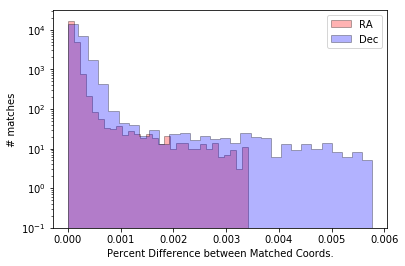

In [23]:
plt.figure()
kwargs = dict(histtype='stepfilled', edgecolor='k', alpha=0.3, bins=30, log=True)
plt.hist(ra_diffs, **kwargs, color='red', label='RA')
plt.hist(dec_diffs, **kwargs, color='blue', label='Dec')
plt.xlabel("Percent Difference between Matched Coords.")
plt.ylabel("# matches")
plt.legend(loc="best")
plt.show()

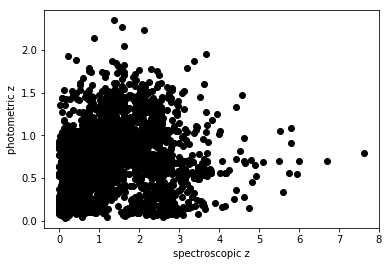

In [24]:
specz = cmatched['specZ']
photz = cmatched['photZ']

plt.figure()
plt.plot(specz, photz, 'ko')
plt.xlabel("spectroscopic z")
plt.ylabel("photometric z")
plt.show()

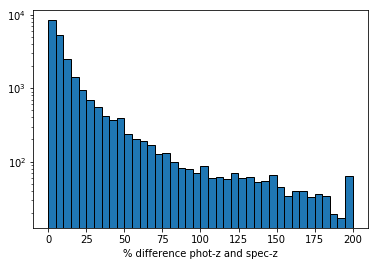

In [25]:
# Compute percent differences for each
zdiff = [pdiff(i,j) for i,j in zip(specz, photz)]
plt.figure()
plt.hist(zdiff, bins=40, edgecolor='k', log=True)
plt.xlabel("% difference phot-z and spec-z")
plt.show()

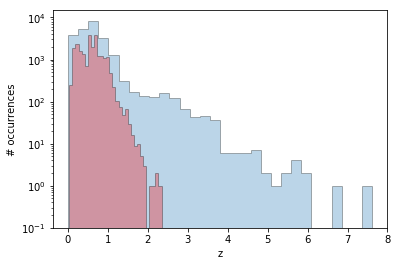

In [26]:
plt.figure()
plt.hist(specz, **kwargs, label="Spectroscopic")
plt.hist(photz, **kwargs, color='red', label="Photometric")
plt.xlabel("z")
plt.ylabel("# occurrences")
plt.show()

# dump

In [27]:
d2d_matches = []
for val in d2d.arcsec:
    if val <= 6.0:
        d2d_matches.append(val)

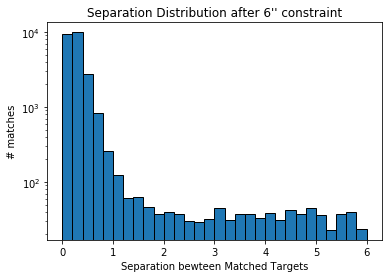

In [28]:
plt.figure()
plt.hist(d2d_matches, bins=30, edgecolor='k', log=True)
plt.xlabel("Separation bewteen Matched Targets")
plt.ylabel("# matches")
plt.title("Separation Distribution after 6'' constraint")
plt.show()

## Merge the matched spec-z data into the phot-z file

In [29]:
count = 0
for i in range(0, len(pdf["ID_1"])):
    if np.isin

SyntaxError: invalid syntax (<ipython-input-29-aa373fc30691>, line 3)

In [78]:
idx

array([   618, 347006, 318473, ..., 207563, 207563, 207561])

## Analysis

In [30]:
# Determine average percent difference between matched coordinates
def pdiff(a, b):
    return np.float128(np.abs(2*np.abs(a-b)/(a+b)) * 100)

ra_diffs, dec_diffs = [], []

for ra1, ra2 in zip(p_matches.ra.value, s_matches.ra.value):
    ra_diffs.append(pdiff(ra1, ra2))
for dec1, dec2 in zip(p_matches.dec.value, s_matches.dec.value):
    dec_diffs.append(pdiff(dec1, dec2))

NameError: name 'p_matches' is not defined

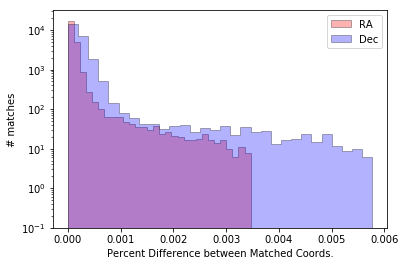

In [48]:
plt.figure()
kwargs = dict(histtype='stepfilled', edgecolor='k', alpha=0.3, bins=30, log=True)
plt.hist(ra_diffs, **kwargs, color='red', label='RA')
plt.hist(dec_diffs, **kwargs, color='blue', label='Dec')
plt.xlabel("Percent Difference between Matched Coords.")
plt.ylabel("# matches")
plt.legend(loc="best")
plt.show()

In [64]:
pdf

,ID_1,RA_1,DEC_1,bestEstimate
0,2961,51.682253,-29.112861,0.614729
1,2981,51.682333,-29.039217,1.013670
2,2987,51.682359,-28.936759,0.545062
3,2988,51.682368,-28.919109,0.974893
4,2996,51.682405,-28.907736,1.163390
5,3014,51.682509,-29.081215,1.125250
6,3029,51.682574,-29.087862,0.363492
7,3045,51.682648,-28.944596,1.474350
8,3065,51.682753,-29.014986,0.614922
9,3078,51.682827,-28.827320,1.044780


# dump

In [97]:
def find_closest_matches(scatalog, pcatalog, idx, d2d):
    # Go through every possible value of idx, one after the other.
    newdf = []
    for i in range(min(idx), max(idx)+1):
        
        # For each value of i, figure out the indices in idx where i is located.
        located_in_idx = np.where(np.array(idx) == i)
        if len(located_in_idx[0]) == 0:
            continue # do something here to make another line? so that the new catalog has the right length? you might need to start at zero.
        
        # The indices `located_in_idx` will fit into the shape of d2d. Plug them in, and figure out which one minimizes the d2d values.
        distances = d2d[located_in_idx] # `distances` will have a new set of indices that you don't want to deal with
        dist_with_orig_ind = [tuple([i,j]) for i,j in zip(located_in_idx[0], distances.value)] # original index with distance attached
        
        minv = dist_with_orig_ind[0]
        for tup in dist_with_orig_ind:
            # loop through and minimize.
            if tup[1] < minv[1]:
                minv = tup
            else:
                pass
            
        # Now you have the minimum value in distances and the original index in idx that goes with it.
        # Now just match scatalog[idx[i]] to pcatalog[i].
        newdf.append([idx[i], scatalog[idx[i]].ra.value, scatalog[idx[i]].dec.value, pcatalog[i].ra.value, pcatalog[i].dec.value,
                     d2d[i].arcsec, data["ZBEST"][idx[i]]])
    newdf = pd.DataFrame(newdf, columns=["index", "SpecRA", "SpecDec", "PhotRA", "PhotDec", "Separation", "SpecZ"])
    return newdf

In [98]:
matched_coords = find_closest_matches(scatalog, pcatalog, idx, d2d)

In [106]:
for i, val in enumerate(sra):
    if val == matched_coords["SpecRA"][15]:
        print(val, sz[i], i, idx[i])

In [107]:
matched_coords

,index,SpecRA,SpecDec,PhotRA,PhotDec,Separation,SpecZ
0,322,51.692128,-28.711904,51.653080,-28.672560,94.498359,0.329200
1,384,51.693057,-28.114734,51.660917,-28.720361,46.510638,0.107980
2,319,51.692072,-28.771320,51.662583,-28.585750,103.137028,0.561500
3,373,51.692929,-27.914379,51.664833,-27.703750,28.560431,0.995320
4,384,51.693057,-28.114734,51.669792,-28.150583,44.817741,0.107980
5,350,51.692665,-28.761854,51.670542,-28.535222,31.648642,1.530330
6,404,51.693416,-27.633078,51.671500,-28.757940,106.952426,0.595270
7,374,51.692935,-28.984898,51.675708,-28.476111,28.190529,0.216560
8,409,51.693551,-29.023103,51.677792,-27.952583,109.998255,0.116759
9,366,51.692852,-28.898459,51.679040,-27.799830,177.207831,0.110363


## Analyze the matches

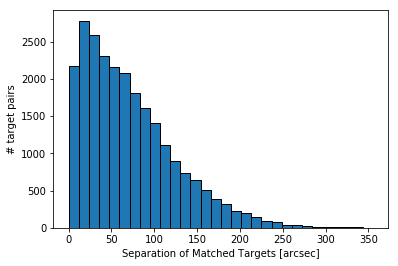

In [54]:
plt.figure()
plt.hist(matched_coords["Separation"], 30, edgecolor='k')
plt.xlabel("Separation of Matched Targets [arcsec]")
plt.ylabel("# target pairs")
plt.show()

## Constrain the matches to below 6'' separation